In [ ]:
import pandas as pd
import numpy as np
!pip install lime

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from lime.lime_tabular import LimeTabularExplainer
!pip install shap
import shap

pd.set_option('display.max_columns', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d868f30fdf2d7c510080ab79fdb842d1c7ead95c3d542db2822c37f1616cc221
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.0 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shareddrives/XAI_RL_MARL_RLHF/Notebooks/Baselines'

Mounted at /content/drive
/content/drive/Shareddrives/XAI_RL_MARL_RLHF/Notebooks/Baselines


In [ ]:
# Load (preprocessed) data
#
# The raw data was downloaded from https://data.stanford.edu/hcmst and preprocessed.
# We combined data sets collected across several years, we transformed select variables
# (e.g., partner_education to be at the same level of granularity as education),
# and added variables like the absolute age difference, education difference, etc.
# Finally, we determined whether couples were still together (i.e., our labels).
#
# We provide the preprocessed data as a csv file in the same repo as this notebook.

df = pd.read_csv('couples.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['age',
                 'partner_age',
                 'age_diff_abs',
                 'children',
                 'visits_relatives',
                 'education',
                 'marital_status',
                 'partner_education',
                 'gender',
                 'house',
                 'income',
                 'msa',
                 'rent',
                 'political',
                 'religion',
                 'work',
                 'gender_older',
                 'education_difference',
                 'success']

data = df[feature_order]
data = data[data.house != 'boat, rv, van, etc.'] # only one data point with this value, discard

labels = data.pop('success')

In [ ]:
# Take a peak at the data
data.head()

,age,partner_age,age_diff_abs,children,visits_relatives,education,marital_status,partner_education,gender,house,income,msa,rent,political,religion,work,gender_older,education_difference
0,52,48,4,0.0,0,bachelor's degree or higher,living with partner,some college,female,a building with 2 or more apartments,"$20,000 to $24,999",metro,rented for cash,democrat,catholic,working - as a paid employee,1,1
1,28,30,2,0.0,0,bachelor's degree or higher,living with partner,bachelor's degree or higher,female,a building with 2 or more apartments,"$40,000 to $49,999",metro,rented for cash,democrat,jewish,working - as a paid employee,0,0
2,31,40,9,0.0,1,some college,never married,high school,male,a building with 2 or more apartments,"$40,000 to $49,999",metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,1,1
3,53,55,2,0.0,1,bachelor's degree or higher,living with partner,bachelor's degree or higher,male,a one-family house detached from any other house,"$125,000 to $149,999",metro,owned or being bought by you or someone in you...,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,1,0
4,58,51,7,0.0,0,bachelor's degree or higher,separated,bachelor's degree or higher,male,a building with 2 or more apartments,"$15,000 to $19,999",metro,rented for cash,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,0,0


In [ ]:
# Define categorical names and indices
categorical_features = list(data.columns[5:])
categorical_idx = list(range(5, len(data.columns)))
continuous_features = list(data.columns[0:5])
continuous_idx = list(range(0,5))

X = data.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
train, test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.70, random_state=42
)

In [ ]:
np.shape(train)

(1030, 18)

In [ ]:
np.shape(test)

(442, 18)

In [ ]:
# Preprocessing pipeline
#
# LIME needs a function that takes raw inputs and returns a prediction (see below).
# We use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME (see below).
# There are several ways to build this pipeline. For demo purposes, we here show the verbose option (and we
# avoid scaling one-hot encoded features).

continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

# There are less verbose alternatives, especially if we scale one-hot encoded features,
# an accepted practice in the machine learning community:
#
#     preprocessing_pipeline = Pipeline([
#        ('onehotencoder', OneHotEncoder(categorical_features=categorical_idx, sparse=False)),
#        ('scaler', StandardScaler())
#     ])
#
# Finally, instead of the low-level Pipeline constructor, we can use sklearn's makepipeline:
#
#     preprocessing_pipeline = make_pipeline(
#         OneHotEncoder(categorical_features=categorical_idx, sparse=False),
#         StandardScaler()
#     )

In [ ]:
train

array([[32., 51., 19., ...,  5.,  0.,  1.],
       [47., 49.,  2., ...,  5.,  0.,  1.],
       [72., 65.,  7., ...,  4.,  0.,  1.],
       ...,
       [49., 58.,  9., ...,  5.,  0.,  1.],
       [63., 61.,  2., ...,  1.,  0.,  0.],
       [32., 29.,  3., ...,  6.,  0.,  2.]])

In [ ]:
labels_train

135     1.0
1100    1.0
478     1.0
975     1.0
436     1.0
       ... 
1131    1.0
1295    1.0
861     1.0
1460    1.0
1127    1.0
Name: success, Length: 1030, dtype: float64

In [ ]:
# Set up the model and GridSearch for random forest hyperparameter tuning
param_grid = [{'n_estimators': [16, 20, 24],
               'max_features': [4, 8, 12, 16],
               'min_samples_split': [8, 12, 16],
               'max_depth': [15, 20, 25]}]

rf = RandomForestClassifier(class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

# Extend the preprocessing pipeline to include random forest and grid search
pipeline = make_pipeline(preprocessing_pipeline, grid_search)

# Fit the model and tune the hyperparameters
pipeline.fit(train, labels_train)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('continuous_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  DataSelector(attribute_indices=[0,
                                                                                                  1,
                                                                                                  2,
                                                                                                  3,
                                                                                                  4])),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('categorical_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  DataSelector(attribute_indices=[5,
                                                                                                  6,
                                                                                                  7,
                                                                                                  8,
                                                                                                  9,
                                                                                                  10,
                                                                                                  11,
                                                                                                  12,
                                                                                                  13,
                                                                                                  14,
                                                                                                  15,
                                                                                                  16,
                                                                                                  17])),
                                                                 ('encoder',
                                                                  OneHotEncoder(sparse=False,
                                                                                sparse_output=False))]))])),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(class_weight='balanced'),
                              param_grid=[{'max_depth': [15, 20, 25],
                                           'max_features': [4, 8, 12, 16],
                                           'min_samples_split': [8, 12, 16],
                                           'n_estimators': [16, 20, 24]}],
                              scoring='neg_mean_squared_error'))])

In [ ]:
# Hyperparameters found by GridSearchCV
print(pipeline.named_steps['gridsearchcv'].best_params_)

{'max_depth': 25, 'max_features': 12, 'min_samples_split': 12, 'n_estimators': 20}


In [ ]:
# Evalute random forest classifier on training data (it overfits, small sample size)
y_predict = pipeline.predict(train)
f1 = f1_score(labels_train, y_predict)
print('F1 on train:', f1)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
f1 = f1_score(labels_test, y_predict)
print('F1 on test:', f1)

F1 on train: 0.9408706952566602
F1 on test: 0.8776119402985075


In [ ]:
# Get feature importances of random forest model ("global interpretability")
best_estimator = pipeline.named_steps['gridsearchcv'].best_estimator_

importances = best_estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_names = data.columns
for f in range(data.shape[1]):
    print("%2d. feature %s (%f)" %
          (f + 1, feature_names[f], importances[indices[f]]))

Feature ranking:
 1. feature age (0.301202)
 2. feature partner_age (0.108565)
 3. feature age_diff_abs (0.075116)
 4. feature children (0.062439)
 5. feature visits_relatives (0.046711)
 6. feature education (0.036658)
 7. feature marital_status (0.035251)
 8. feature partner_education (0.028319)
 9. feature gender (0.013659)
10. feature house (0.013521)
11. feature income (0.011959)
12. feature msa (0.010726)
13. feature rent (0.009989)
14. feature political (0.009600)
15. feature religion (0.008905)
16. feature work (0.008512)
17. feature gender_older (0.008376)
18. feature education_difference (0.008354)


In [ ]:
# Use LIME to explain individual predictions, initialize explainer object
lime_explainer = LimeTabularExplainer(
    train,
    class_names=['BrokeUp', 'StayedTogether'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

In [ ]:
for i in range(0, 18):
  print(f"{data.columns[i]}={test[182][i]}")

age=53.0
partner_age=37.0
age_diff_abs=16.0
children=0.0
visits_relatives=0.0
education=1.0
marital_status=0.0
partner_education=3.0
gender=1.0
house=3.0
income=6.0
msa=0.0
rent=1.0
political=0.0
religion=2.0
work=6.0
gender_older=0.0
education_difference=1.0


In [ ]:
import pandas as pd
labels_test.to_frame().iloc[182][0]

0.0

In [ ]:
print(type(labels_test[10]))
type(labels_test.to_frame().index.values[10])

<class 'numpy.float64'>


numpy.int64

In [ ]:
for feature, value in data.loc[labels_test.to_frame().index.values[10]].items():
  print(f"{feature}={value}")

age=31
partner_age=30
age_diff_abs=1
children=0.0
visits_relatives=2
education=bachelor's degree or higher
marital_status=never married
partner_education=some college
gender=male
house=a building with 2 or more apartments
income=$40,000 to $49,999
msa=metro
rent=rented for cash
political=democrat
religion=buddhist
work=working - as a paid employee
gender_older=0
education_difference=1


In [ ]:
pipeline.predict(test[182].reshape(1,-1))

array([0.])

In [ ]:
import matplotlib.pyplot as plt
# Explain a prediction ("local interpretability"):
# Now we see that the pipeline that takes raw data and returns the prediction
# of the trained model now comes in conveniently.
example = 182
exp = lime_explainer.explain_instance(test[3], pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
fig = exp.as_pyplot_figure()
plt.title("LIME: Local Agnostic Interpretable Model-Agnostic Explanations")
plt.savefig('lime_couples_rfte_3_titles.png', bbox_inches='tight')

Couples probability of staying together: 0.9309655389687439


In [ ]:
lime_explainer = LimeTabularExplainer(
    train,
    class_names=['StayedTogether', 'BrokeUp'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    # categorical_names=categorical_names,
    discretize_continuous=True
)

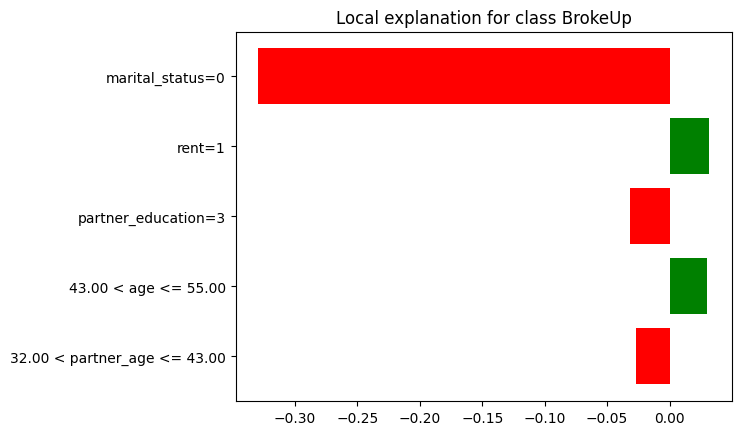

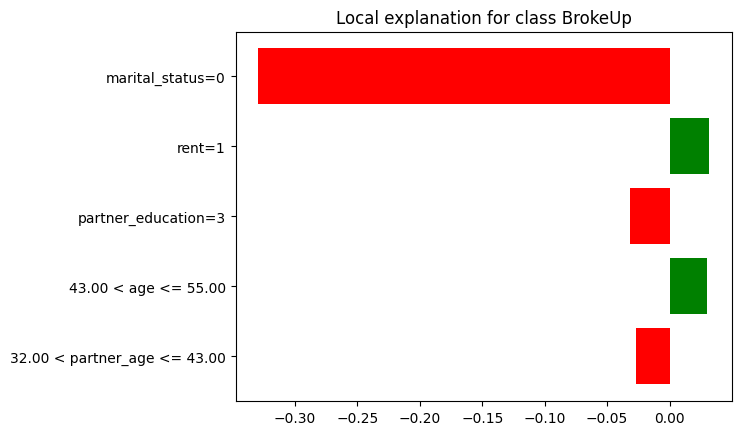

In [ ]:
exp = lime_explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
# print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [ ]:
def strip_feature_descriptions(input_str):
    keywords = list(data.columns)

    for keyword in keywords:
        if keyword in input_str:
            return keyword

In [ ]:
lime_str = "LIME scores for the features "
for tup in exp.as_list()[:5]:
  lime_str += f"{strip_feature_descriptions(tup[0])}, "

lime_str += "are, respectively, "
for tup in exp.as_list()[:5]:
  lime_str += f"{round(tup[1], 4)}, "


print(lime_str)

LIME scores for the features marital_status, rent, education, age, age, are, respectively, -0.3296, 0.0317, -0.0314, 0.0304, -0.0268, 


In [ ]:
shap_explainer = shap.Explainer(pipeline.predict_proba, train, feature_names=list(data.columns))
shap_values = shap_explainer(test)

Permutation explainer: 443it [01:12,  5.58it/s]


In [ ]:
len(list(data.columns))

18

In [ ]:
train.shape

(1030, 18)

In [ ]:
test.shape

(442, 18)

In [ ]:
import matplotlib.pyplot as plt
shap_exp = shap.Explanation(shap_values.values, shap_values.base_values[0][0], shap_values.data, feature_names=list(data.columns))
print(list(data.columns))
plt.clf()
shap.plots.waterfall(shap_exp[3,:,1], show=False, max_display=5)
plt.title("SHAP: Shapley Additive Explanations")
plt.savefig('shap_couples_rfte_3.png', bbox_inches='tight')

['age', 'partner_age', 'age_diff_abs', 'children', 'visits_relatives', 'education', 'marital_status', 'partner_education', 'gender', 'house', 'income', 'msa', 'rent', 'political', 'religion', 'work', 'gender_older', 'education_difference']


In [ ]:
shap_exp[0,:,1]

.values =
array([ 0.0401582 ,  0.00824327, -0.03263471, -0.001052  ,  0.00854634,
        0.01226643,  0.14712697, -0.02569429, -0.00935091,  0.00348055,
       -0.00167219,  0.01241835,  0.0078657 , -0.01074031, -0.01780965,
        0.00126581,  0.01619805,  0.00356466])

.base_values =
0.29256995058105495

.data =
array([61., 49., 12.,  0., 50.,  2.,  2.,  2.,  0.,  3., 11.,  1.,  1.,
        0.,  0.,  5.,  1.,  0.])

In [ ]:
shap_exp

.values =
array([[[-0.0401582 ,  0.0401582 ],
        [-0.00824327,  0.00824327],
        [ 0.03263471, -0.03263471],
        ...,
        [-0.00126581,  0.00126581],
        [-0.01619805,  0.01619805],
        [-0.00356466,  0.00356466]],

       [[-0.03569204,  0.03569204],
        [-0.03499219,  0.03499219],
        [-0.001653  ,  0.001653  ],
        ...,
        [-0.00252647,  0.00252647],
        [ 0.00772906, -0.00772906],
        [-0.00485991,  0.00485991]],

       [[-0.01935198,  0.01935198],
        [ 0.01026745, -0.01026745],
        [-0.02883157,  0.02883157],
        ...,
        [ 0.00152157, -0.00152157],
        [ 0.00062997, -0.00062997],
        [ 0.01343484, -0.01343484]],

       ...,

       [[-0.00178129,  0.00178129],
        [ 0.00805637, -0.00805637],
        [-0.00179231,  0.00179231],
        ...,
        [-0.00306513,  0.00306513],
        [-0.00509345,  0.00509345],
        [-0.00827449,  0.00827449]],

       [[-0.03175817,  0.03175817],
        [-0.02363

In [ ]:
shap_str = "SHAP scores for the features "
shap_val_list = [(name, val) for name, val in zip(data.columns, shap_exp[example,:,1].values)]
shap_val_list = sorted(shap_val_list, key=lambda x: abs(x[1]), reverse=True)
for name in shap_val_list[:5]:
  shap_str += f"{name[0]}, "

shap_str += "are, respectively, "
for val in shap_val_list[:5]:
  shap_str += f"{round(val[1], 4)}, "


print(shap_str)

SHAP scores for the features marital_status, religion, visits_relatives, partner_age, age, are, respectively, -0.2737, 0.029, -0.0216, -0.0208, 0.0201, 


Couples probability of staying together: 0.5970688809711671


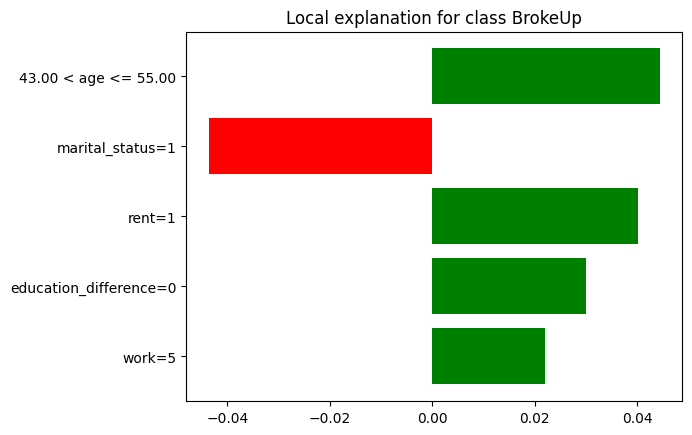

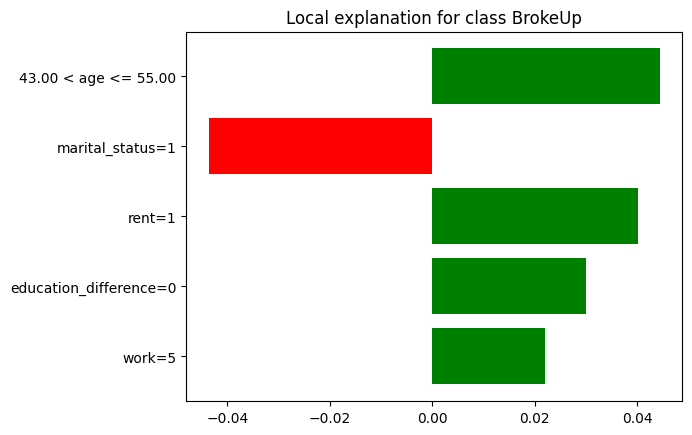

In [ ]:
# Explain another prediction ("local interpretability"):
example = 13
exp = lime_explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [ ]:
labels_test[10]

0.0

In [ ]:
# # Using LIME for for relationship management (not advised): Current chance of relationship success.
# current = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 18, 0, 2, 0, 8, 4, 0, 0]
# exp = explainer.explain_instance(np.array(current), pipeline.predict_proba, num_features=5)
# print('Couples probability of staying together:', exp.predict_proba[1])
# exp.as_pyplot_figure()

In [ ]:
# Should I ask for a pay increase? It doesn't matter much.
increase_income = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(increase_income), pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

NameError: ignored

In [ ]:
# Should I buy a house? Maybe?
buy_house = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(buy_house), pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [ ]:
# Really, it's best to get married.
get_married = [34, 36, 2, 0, 1, 0, 2, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(get_married), pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [ ]:

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)
